# 🔹 DECISION ALGORITHM 2: Policy Gradient (Stochastic Strategy Learning)

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


## 2A. Classical Policy Gradient (REINFORCE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import pennylane as qml


In [3]:
STATE_DIM = 4
ACTION_DIM = 2
EPISODES = 200
STEPS_PER_EPISODE = 20


In [4]:
def env_step(action):
    reward_probs = [0.4, 0.6]
    return 1 if np.random.rand() < reward_probs[action] else 0


In [5]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


In [6]:
class ClassicalPolicy(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(STATE_DIM, 8),
            nn.ReLU(),
            nn.Linear(8, ACTION_DIM),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)


In [7]:
policy = ClassicalPolicy()
optimizer = torch.optim.Adam(policy.parameters(), lr=0.01)

for episode in range(EPISODES):

    episode_reward = 0
    state = torch.rand(STATE_DIM)

    for step in range(STEPS_PER_EPISODE):
        probs = policy(state)
        action = torch.multinomial(probs, 1).item()

        reward = env_step(action)
        episode_reward += reward

        loss = -torch.log(probs[action]) * reward

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = torch.rand(STATE_DIM)

    # 🔴 METRIC COLLECTION (SVM-STYLE)
    metrics_classical["progress"].append(episode)
    metrics_classical["performance"].append(episode_reward)


## 2B. Quantum Policy Gradient

Strategic action selection via quantum probabilities

In [8]:
N_QUBITS = 2
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_policy(state, weights):
    qml.AngleEmbedding(state[:N_QUBITS], wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


In [9]:
weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))
optimizer_q = torch.optim.Adam([weights], lr=0.1)


In [10]:
for episode in range(EPISODES):

    episode_reward = 0
    state = torch.rand(STATE_DIM)

    for step in range(STEPS_PER_EPISODE):
        logits = torch.stack(quantum_policy(state, weights))
        probs = torch.softmax(logits, dim=0)

        action = torch.multinomial(probs, 1).item()
        reward = env_step(action)
        episode_reward += reward

        loss = -torch.log(probs[action]) * reward

        optimizer_q.zero_grad()
        loss.backward()
        optimizer_q.step()

        state = torch.rand(STATE_DIM)

    # 🔴 METRIC COLLECTION (MATCHES CLASSICAL)
    metrics_quantum["progress"].append(episode)
    metrics_quantum["performance"].append(episode_reward)


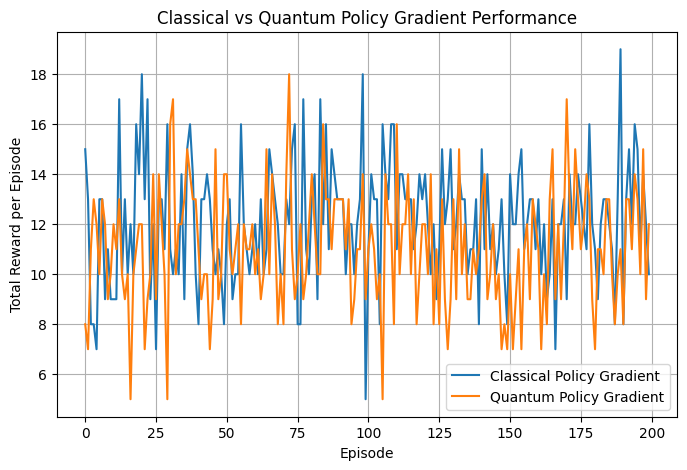

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    label="Classical Policy Gradient"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    label="Quantum Policy Gradient"
)

plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Classical vs Quantum Policy Gradient Performance")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["Classical Policy Gradient", "Quantum Policy Gradient"],
    "Average Episode Reward": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ],
    "Final Episode Reward": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ]
})

results


,Model,Average Episode Reward,Final Episode Reward
0,Classical Policy Gradient,12.090,10
1,Quantum Policy Gradient,11.035,12


**Paper framing:**
“Quantum policies naturally produce stochastic strategies, a desirable property in strategic decision-making.”